## Exercise 5 - Problem 1

Problem 1: Visualize a static map (8 points)

Create a static map using the skills you learned in lesson 5. The map should contain multiple layers of data (at least two different data sets), and you should pay attention to the classification and visualization (colors, edges etc.) when creating the map. Write your code into a notebook file (`.ipynb`) or a python script file (`.py`) and store the output map(s) in `.png` format into the `docs` folder.

**Topic of the map:**
- You can either use the data sets we have already used during this course (eg. the Travel Time Matrix, or population grid), or you can select some other data set of your interest (for example, statistics in postal code areas).
- Feel free to adapt examples provided in this course! You can do further calculations based on the datasets or use the analysis outputs that we have done earlier in the course (for example, the dominance areas or travel times for shopping centers). 

**Criteria:**
- The map should have multiple layers on it (for example, the travel time matrix and the road network). Basemap is optional (use a basemap only if it adds useful information / visual touch!)
- The map should portray some kind of classification and/or an analysis output (not just the raw data).
- Consider [good cartographic practices](https://www.gislounge.com/ten-things-to-consider-when-making-a-map/) (map extent, zoom level, color choices, legend, credit data sources etc.) when plotting the map.

**Output:**
- Remember to commit the code and input data (or at least a link to input data)
- Save your map(s) as png image in the **`docs`** folder

In [2]:
# Import the necessary modules
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline

# Filepaths
url = 'http://geo.stat.fi/geoserver/tilastointialueet/wfs?request=GetFeature&typename=tilastointialueet:kunta1000k&outputformat=JSON'
url_vaesto = 'https://geo.stat.fi/geoserver/vaestoruutu/wfs?service=WFS&request=GetFeature&typename=vaestoruutu:vaki2020_5km&outputformat=json' 

# Read the data
municipality = gpd.read_file(url)
population = gpd.read_file(url_vaesto)

# Check the crs of all data
print(municipality.crs)
print(population.crs)

epsg:3067
epsg:3067


In the static map I examine the population of Joensuu

In [3]:
# Select the municipality to examine
joensuu = municipality.loc[municipality['nimi'] == 'Joensuu']

# Select the needed columns
joensuu = joensuu[['kunta', 'nimi', 'geometry']]

# Make the intersection
intersection = gpd.overlay(population, joensuu, how='intersection')

intersection.crs==joensuu.crs

True

In [4]:
print(len(intersection))
intersection.head(3)

142


,id,grd_id,id_nro,xkoord,ykoord,kunta_1,vaesto,miehet,naiset,ika_0_14,ika_15_64,ika_65_,kunta_2,nimi,geometry
0,vaki2020_5km.4134,5kmN6905E0695,8363,695000,6905000,848,9,-1,-1,-1,-1,-1,167,Joensuu,"POLYGON ((695778.006 6910000.000, 697737.508 6..."
1,vaki2020_5km.4231,5kmN6910E0690,8497,690000,6910000,848,13,6,7,0,5,8,167,Joensuu,"POLYGON ((693478.747 6915000.000, 695000.000 6..."
2,vaki2020_5km.4232,5kmN6910E0695,8498,695000,6910000,167,21,10,11,2,11,8,167,Joensuu,"POLYGON ((695000.000 6911691.862, 695000.000 6..."


<AxesSubplot:>

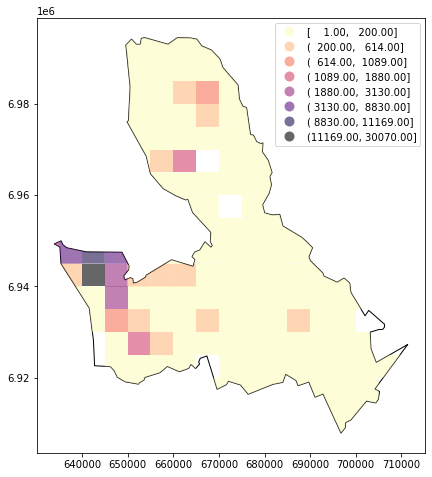

In [5]:
# Test plot of the data
fig, ax = plt.subplots(figsize=(10,8))
joensuu.plot(ax=ax, color='None', edgecolor='k')
intersection.plot(ax=ax, column='vaesto' , scheme='NaturalBreaks', k=8, cmap='magma_r', legend=True, alpha=0.6)

In [6]:
"""# Change the crs suitable for the basemap
intersection = intersection.to_crs(epsg=3857)
joensuu = joensuu.to_crs(epsg=3857)
print(joensuu.crs, intersection.crs)"""

'# Change the crs suitable for the basemap\nintersection = intersection.to_crs(epsg=3857)\njoensuu = joensuu.to_crs(epsg=3857)\nprint(joensuu.crs, intersection.crs)'

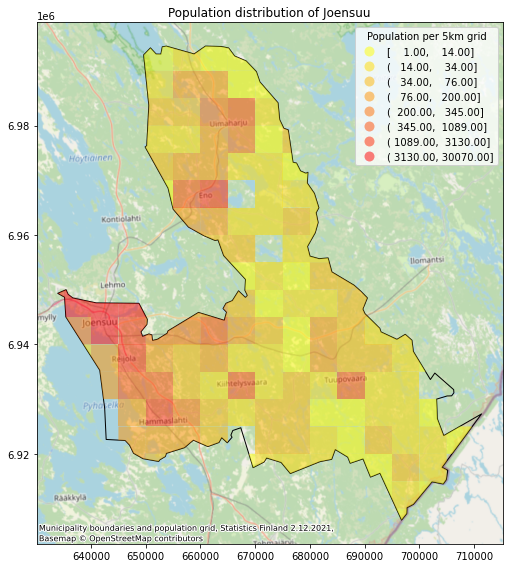

In [8]:
# Create the figure and plot
fig, ax = plt.subplots(figsize=(10,8))
joensuu.plot(ax=ax, color='None', edgecolor='k')
intersection.plot(ax=ax, column='vaesto', scheme='JenksCaspall', k=8, cmap='autumn_r', legend=True, alpha=0.5)

# Add credits
credits = 'Municipality boundaries and population grid, Statistics Finland 2.12.2021,\nBasemap © OpenStreetMap contributors'

# Add basemap
ctx.add_basemap(ax, crs=joensuu.crs, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik, zoom=9)

# Add title
plt.title('Population distribution of Joensuu')

# Set a title for the legend
ax.get_legend().set_title("Population per 5km grid")

# Remove the empty white-space around the axes
plt.tight_layout()

#### For the interactive map, I will use some easier data, OR test the roads there??? Toi väestöjakauma toimis kans interaktiivisessa kartassa mut jaksaako säätää

In [45]:
import folium
import requests
import geojson

# Change the crs suitable for the basemap
intersection = intersection.to_crs(epsg=3857)
joensuu = joensuu.to_crs(epsg=3857)
print(joensuu.crs, intersection.crs)

intersection['geoid'] = intersection.index.astype(str)

m = folium.Map(location=[62.6448,30.2552], zoom_start=9, crs='EPSG3857')

folium.Choropleth(
    geo_data=intersection,
    name='Population in Joensuu',
    data=intersection,
    columns=['geoid', 'vaesto'],
    key_on='feature.id',
    fill_color='YlOrRd',
    line_weight=0,
    legend_name='Population in 5km grid'
).add_to(m)

"""grid_gjson = folium.features.GeoJson(intersection, name='Population per 5km grid')
grid_gjson.add_to(m)
folium.features.LatLngPopup"""

# Add a layer control object to the map
folium.LayerControl().add_to(m)

m

epsg:3857 epsg:3857


In [46]:
# Convert points to GeoJson
folium.features.GeoJson(intersection,  
                        name='Labels',
                        style_function=lambda x: {'color':'transparent','fillColor':'transparent','weight':0},
                        tooltip=folium.features.GeoJsonTooltip(fields=['vaesto'],
                                                                aliases = ['Population'],
                                                                labels=True,
                                                                sticky=False
                                                                            )
                       ).add_to(m)

m


In [86]:
url_paavo = 'https://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2021&outputformat=JSON'

paavo = gpd.read_file(url_paavo)

# Crop the postal code data to Joensuu area
joe = paavo.loc[paavo['kunta']=='167']

In [81]:
"""he_kika  Average age of inhabitants, 2019
te_elak  Pensioner households, 2019
ra_raky  Buildings, total, 2019
ra_ke  Free-time residences, 2019

"""
joe.columns

Index(['id', 'postinumeroalue', 'nimi', 'namn', 'euref_x', 'euref_y',
       'pinta_ala', 'vuosi', 'kunta', 'he_vakiy',
       ...
       'tp_u_kans', 'tp_x_tunt', 'pt_vakiy', 'pt_tyoll', 'pt_tyott', 'pt_0_14',
       'pt_opisk', 'pt_elakel', 'pt_muut', 'geometry'],
      dtype='object', length=113)

In [87]:
# Select only the necessary columns
joe = joe[['postinumeroalue', 'nimi', 'euref_x', 'euref_y',  'pinta_ala', 'ra_raky', 'ra_ke', 'he_vakiy', 'geometry']]
joe.head()

,postinumeroalue,nimi,euref_x,euref_y,pinta_ala,ra_raky,ra_ke,he_vakiy,geometry
1172,80100,"Joensuu Keskus, Pohjoinen",642401,6946378,9980030,1537,0,9846,"MULTIPOLYGON (((644191.480 6947547.934, 644164..."
1173,80110,Joensuu Keskus Eteläinen,640052,6943755,5443731,372,76,4662,"MULTIPOLYGON (((639872.099 6945277.338, 639994..."
1174,80130,Kanervala,640575,6945688,8393053,1002,2,2603,"MULTIPOLYGON (((640400.805 6950153.301, 640129..."
1175,80140,Noljakka,636459,6945642,25011948,1558,13,8335,"MULTIPOLYGON (((635719.837 6948104.566, 636407..."
1177,80160,Rantakylä-Latola,645212,6946445,6395845,1654,0,10101,"MULTIPOLYGON (((646891.972 6947520.387, 646728..."


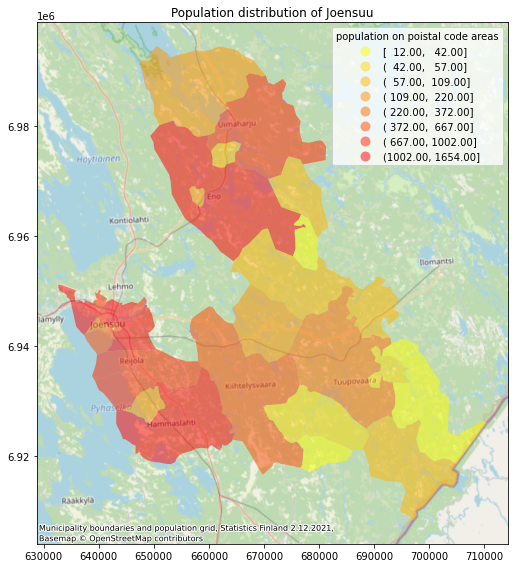

In [91]:
# Create the figure and plot
fig, ax = plt.subplots(figsize=(10,8))
joe.plot(ax=ax, column='ra_raky', scheme='JenksCaspall', k=8, cmap='autumn_r', legend=True, alpha=0.5)

# Add credits
credits = 'Municipality boundaries and population grid, Statistics Finland 2.12.2021,\nBasemap © OpenStreetMap contributors'

# Add basemap
ctx.add_basemap(ax, crs=joe.crs, attribution=credits, source=ctx.providers.OpenStreetMap.Mapnik, zoom=9)

# Add title
plt.title('Population distribution of Joensuu')

# Set a title for the legend
ax.get_legend().set_title("population on poistal code areas")

# Remove the empty white-space around the axes
plt.tight_layout()

In [97]:
# Change the crs suitable for the basemap
joe3857 = joe.to_crs(epsg=3857)

joe3857['geoid'] = joe.index.astype(str)

n = folium.Map(location=[62.6448,30.2552], zoom_start=9, crs='EPSG3857')

folium.features.GeoJson(joe,  
                        name='Labels',
                        style_function=lambda x: {'color':'gray','fillColor':'gray','edgecolor':'k','weight':0.5},
                        tooltip=folium.features.GeoJsonTooltip(fields=['ra_raky'],
                                                                aliases = ['Buildings'],
                                                                labels=True,
                                                                sticky=False
                                                                            )
                       ).add_to(n)

n